In [1]:
import torch 
from torch import nn

import numpy as np
import math
import matplotlib.pyplot as plt

import pandas as pd

from utils.create_data import *

In [2]:
torch.manual_seed(111)

# Training Data 

In [ ]:
trainig_data_length = 1024
train_data = torch.zeros((trainig_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(trainig_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(trainig_data_length)
#tensor labels just bcz required by pytorch data loader but not used bcz gans use unsupervised learning techniques
train_set = [
    (train_data[i], train_labels[i]) for i in range(trainig_data_length)
]

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [ ]:
#Pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# Discriminator

In [ ]:
#takes as an entry the real/fake data and returns the probability of the input being real
#dim of entry is 2, dim of output is 1
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output


In [ ]:
discriminator = Discriminator()

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), # a vector of 2 elements and no activation function so it can range from -inf to inf 
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
generator = Generator()

# Training the Models

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
print(train_loader)

In [ ]:
for epoch in range(num_epochs):
    #each batch is a tuple (real_samples, labels) where real_samples is a tensor of batch_size (32) data
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

In [ ]:
generated_samples = generated_samples.detach()
#since the generator gives a 2 elemts vector and we pass through it 100 elements, the size of generated_samples is 100x2
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

# MNIST Example

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
#device object to move the data and the models to the GPU if there is any
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
# dim (batch_size, num_channels, heigh, width)
real_samples, mnist_labels = next(iter(train_loader))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
                #dim (1, 28, 28) -> dim (28, 28)
    plt.imshow(real_samples[i].reshape(28,28), cmap = "gray_r")
    #to remove the numbers on axis
    plt.xticks([])
    plt.yticks([])

In [ ]:
#adapting the discriminator to the MNIST dataset
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784,1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        #tensor from dim (batch_size, 1, 28, 28) to dim (batch_size, 784)
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
#to run the discriminator on the GPU
discriminator = Discriminator().to(device=device)    

In [ ]:
class Generator(nn.Module):
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            #100 dimension of the latent space bcz we want more complex data
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            #to have an output between -1 and 1 bcz the data is normalized
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        #to have the output in the same format as the input of the discriminator
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)   

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Gan basique sur les vrais Données 

In [3]:
df = pd.read_csv('./data/GANData.csv')
asset = "UK Government Bond - USD Hedged"
price = df[df['ASSETNAME']==asset]['PRICE']
y = np.log(price/price.shift(1))[1:].to_numpy()
true_y = price.to_numpy()

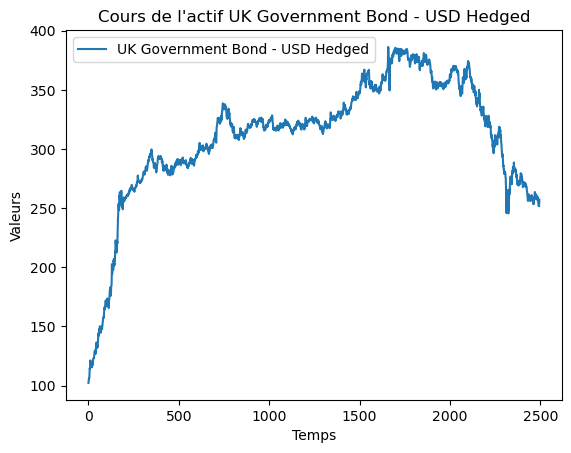

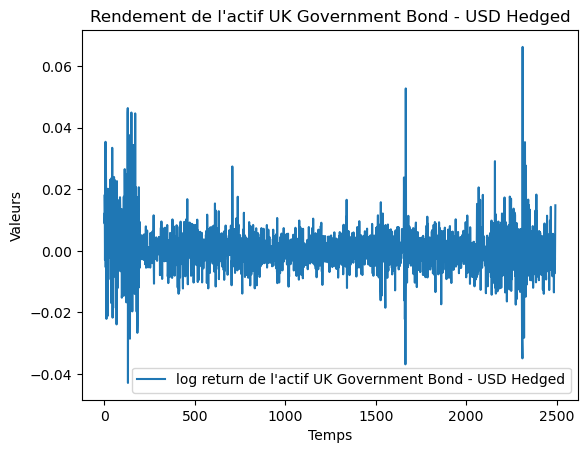

In [4]:
easy_plot(true_y,f"Cours de l'actif {asset}", f"{asset}")
easy_plot(y,f"Rendement de l'actif {asset}", f"log return de l'actif {asset}")

In [5]:
trainin_data_length = len(y)
train_data = torch.zeros((trainin_data_length,2))
train_data[:,0] = torch.arange(trainin_data_length)
train_data[:,1] = torch.from_numpy(y)
train_labels = torch.zeros(trainin_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(trainin_data_length)
]

In [6]:
print(trainin_data_length)

2494


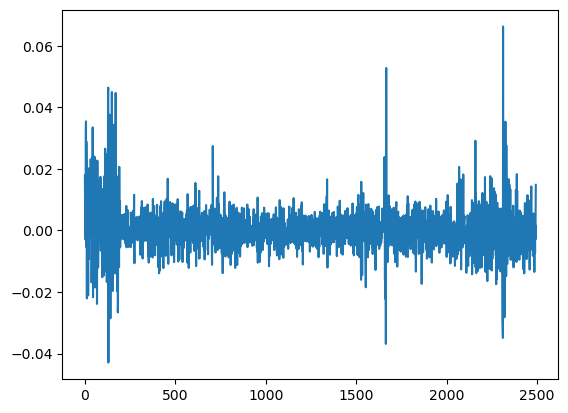

In [7]:
plt.plot(train_data[:, 0], train_data[:, 1])

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [9]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output 

In [10]:
discriminator = Discriminator()

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [16]:
generator = Generator()

In [17]:
lr = 0.0001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [22]:
for epoch in range(num_epochs):
    #each batch is a tuple (real_samples, labels) where real_samples is a tensor of batch_size (32) data
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.00040737478411756456
Epoch: 0 Loss G.: 8.021504402160645
Epoch: 10 Loss D.: 0.00031847687205299735
Epoch: 10 Loss G.: 8.702153205871582
Epoch: 20 Loss D.: 0.00024625289370305836
Epoch: 20 Loss G.: 8.904205322265625
Epoch: 30 Loss D.: 0.0003928727237507701
Epoch: 30 Loss G.: 8.543569564819336
Epoch: 40 Loss D.: 0.0004952654126100242
Epoch: 40 Loss G.: 8.076350212097168
Epoch: 50 Loss D.: 0.0002891058975365013
Epoch: 50 Loss G.: 8.06296443939209
Epoch: 60 Loss D.: 0.0003847061889246106
Epoch: 60 Loss G.: 8.187664985656738
Epoch: 70 Loss D.: 0.00019022106425836682
Epoch: 70 Loss G.: 8.204846382141113
Epoch: 80 Loss D.: 0.0001889812119770795
Epoch: 80 Loss G.: 8.560982704162598
Epoch: 90 Loss D.: 0.00016921402129810303
Epoch: 90 Loss G.: 8.954070091247559
Epoch: 100 Loss D.: 0.00013965304242447019
Epoch: 100 Loss G.: 8.457618713378906
Epoch: 110 Loss D.: 0.00015035182877909392
Epoch: 110 Loss G.: 8.081892967224121
Epoch: 120 Loss D.: 0.00026122003328055143
Epoch: 120 Lo

L'architecture simpliste du générateur et du discriminateur ne permet pas d'avoir de bons résultats, méthodes testés pour améliorer le résultat mais en vain : 
- Ajout d'un bruit gaussien aux données pour prévenir l'overfitting du discriminateur.
- Utilisation de différents lr pour le générateur et le discriminateur

In [39]:
latent_space_samples = torch.randn(2000, 2)
generated_samples = generator(latent_space_samples)

#convert the tensor to a numpy array
generated_samples = generated_samples.detach().numpy()

In [40]:
print(generated_samples.shape)

(2000, 2)


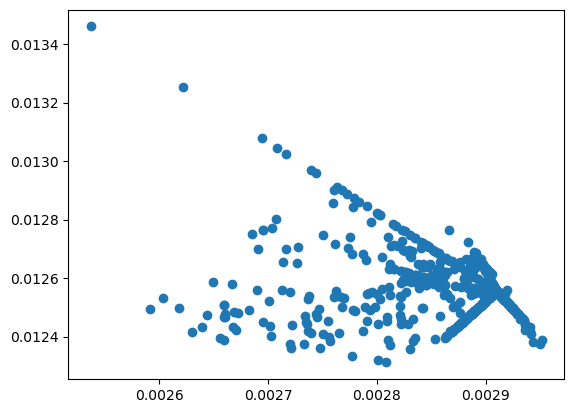

In [43]:
plt.scatter(generated_samples[:, 0], generated_samples[:, 1])